Copyright (c) 2019 Computational-Medicine

# Multiparametric MRI - Tissue classification

**NO:** I denne sesjonen vil du lære å klassifisere vev i multispektrale MR bilder ved bruk av **styrt** (supervised) **klassifikasjon**. For styrt klassifikasjon vil vi benytte treningen (i.e. treningsmasken) med seks ulike klasser (vevstyper) fra forrige sesjon og et motsvarende fire-kanaler multispektralt MR opptak. 

**EN:** In this session you will learn to voxel-wise classify tissue in multispectral MR images using **supervised classification**. For this we will employ the labeling (i.e. training mask) with six different classes (tissue types) used in the previous notebook and a corresponing four-channel multispectral MR recording. 

**THEORY**

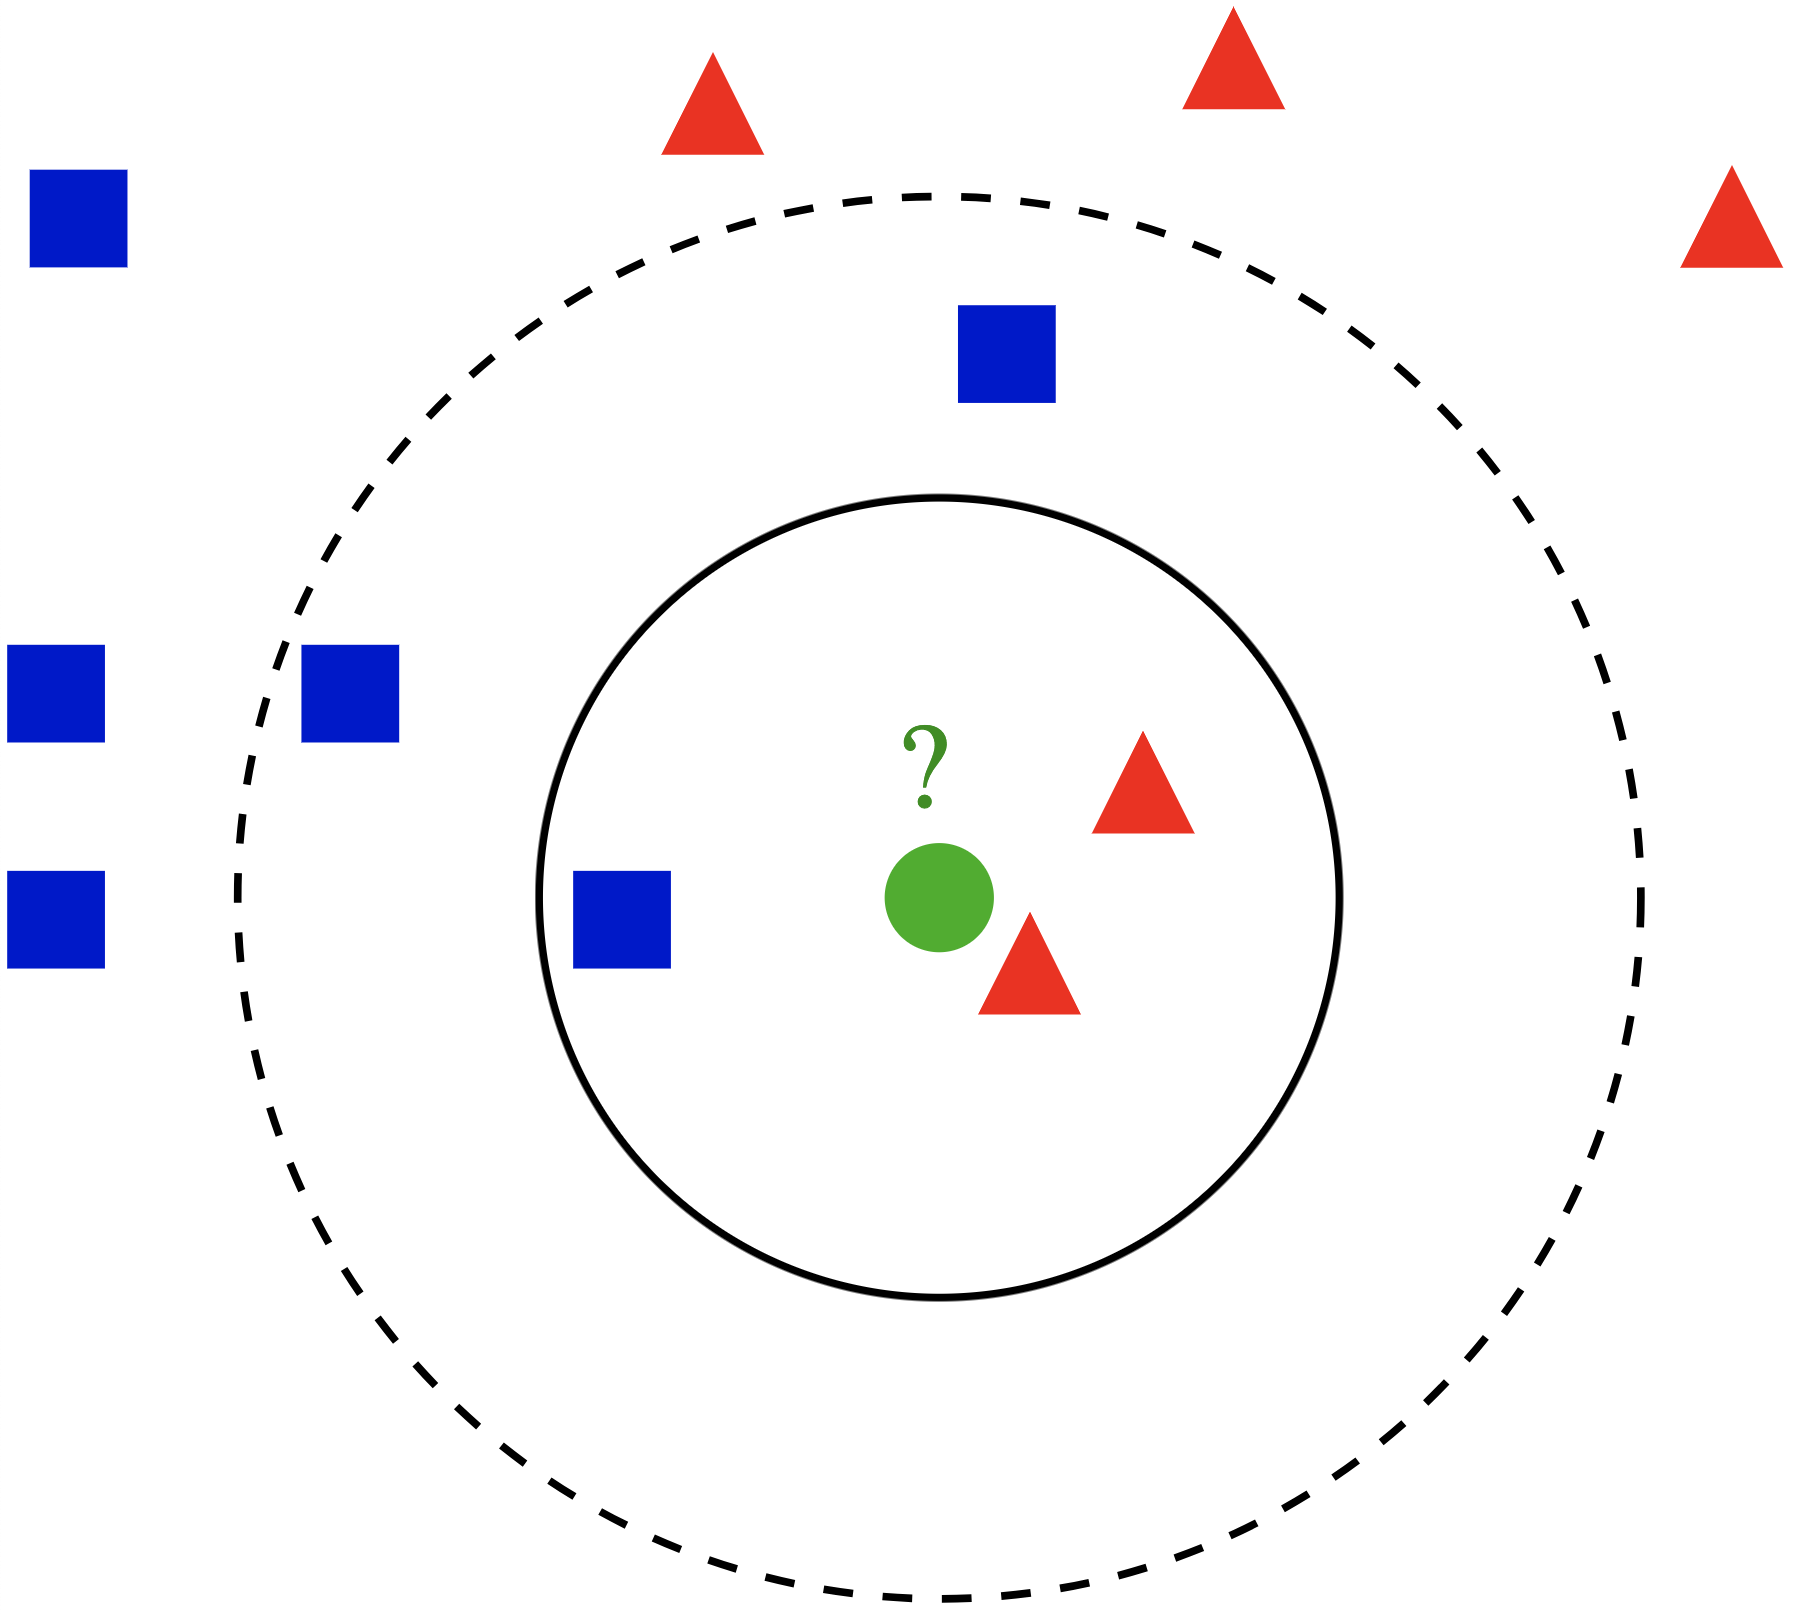

In [1]:
from IPython.display import Image
Image(filename='./assets/knn_illustration.png', width=500)

**NO:** _Eksempel med k-nærmeste nabo (k-NN) klassifikasjon._ 

- Test-observasjonen (fylt grønn sirkel) med ukjent klasse-tilhørighet skal klassifiseres enten til klassen merket med blå kvadrater eller den andre klassen merket med røde triangler. 

- Hvis $k = 3$ (sirkel med heltrukken strek) vil den ukjente observasjonen tilordnes den "røde" klassen siden det er 2 røde triangler og bare 1 blått kvadrat innenfor den innerset sirkel med de 3 nærmeste naboer.

- Hvis $k = 5$ (sirkel med stiplet strek) vil den ukjente observasjonen derimot bli tilordnet den "blå" klassen (3 kvadrater vs. 2 triangler blant de 5 nærmeste naboer), i.e. majoritets-votering. 

- For detaljert forklaring, se [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) på Wikipedia

**EN:** _A k-nearest neighbour (k-NN) classification example._ 

- The test observation (filled green circle) with unknown class belonging shall be classified to either the class labelled with blue squares or the altermative class labelled with red triangles. 

- If $k = 3$ (circel drawn with continues line) the unknown  observation will be allocated to the "red" class since there are two red triangles and only one blue square among the three nearest neighbours ("majority vote").

- If $k = 5$ (circle drawn with dashed line) the unknown  observation will, however, be allocated to the "blue" class since there are three blue squares and only two red triangles among the five nearest neighbours.

- For detailed explanation, see [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) on Wikipedia

**DATA**

**NO**: Figuren nedenfor viser fire-kanals multispektralt bilde (skive 60 fra et multispektral 3D opptak),  <br>
rapportert i  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
og en manuelt tegnet `trenings-maske` med 6 vevstyper (farge-kodet i [R,G,B]) som følger: 

 - AIR (luft/ben) i Magenta [255,0,255]
 - GM  (grå substans) i Rød  [255,0,0] 
 - WM  (hvit substans) i Cyan [0,255,255]
 - CSF (cerebrospinalvæske) i Blå [0,0,255]
 - MUS (muskel) i Grønn [0,255,0] 
 - FAT (fett) i Gul [255,255,0]
 
**Sjekk ut:** *Multispektral MRI analyse startet med arbeidet til [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspirert av forskning ved NASA!*<br>
Se også:<br> T. Taxt, A. Lundervold et al. [Multispectral analysis of uterine corpus tumors in magnetic resonance imaging](https://www.ncbi.nlm.nih.gov/pubmed/1734184). Magn Reson Med. 1992 Jan;23(1):55-76. [[PDF](https://drive.google.com/file/d/19WZ0-sTG9jT8XCTQ3qF_ceG-NbQaX5CZ/view?usp=sharing)]

**EN**: The figure below shows a four-channel multispectral image (slice 60 from a multispectral 3D recording),  <br>
reported in  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
and a manually delineated `training mask` with 6 tissue types (color coded in [R,G,B]) as follows: 

 - AIR (air/bone) in Magenta [255,0,255]
 - GM  (grey matter) in Red  [255,0,0] 
 - WM  (white matter) in Cyan [0,255,255]
 - CSF (cerebrospinal fluid) in Blue [0,0,255]
 - MUS (muscle) in Green [0,255,0] 
 - FAT (fat) in Yellow [255,255,0]
 
**Check out:** *Multispectral MRI analysis started with the seminal work of [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspired by research at NASA!*<br>
See also: <br>
T. Taxt, A. Lundervold et al. [Multispectral analysis of uterine corpus tumors in magnetic resonance imaging](https://www.ncbi.nlm.nih.gov/pubmed/1734184). Magn Reson Med. 1992 Jan;23(1):55-76. [[PDF](https://drive.google.com/file/d/19WZ0-sTG9jT8XCTQ3qF_ceG-NbQaX5CZ/view?usp=sharing)]

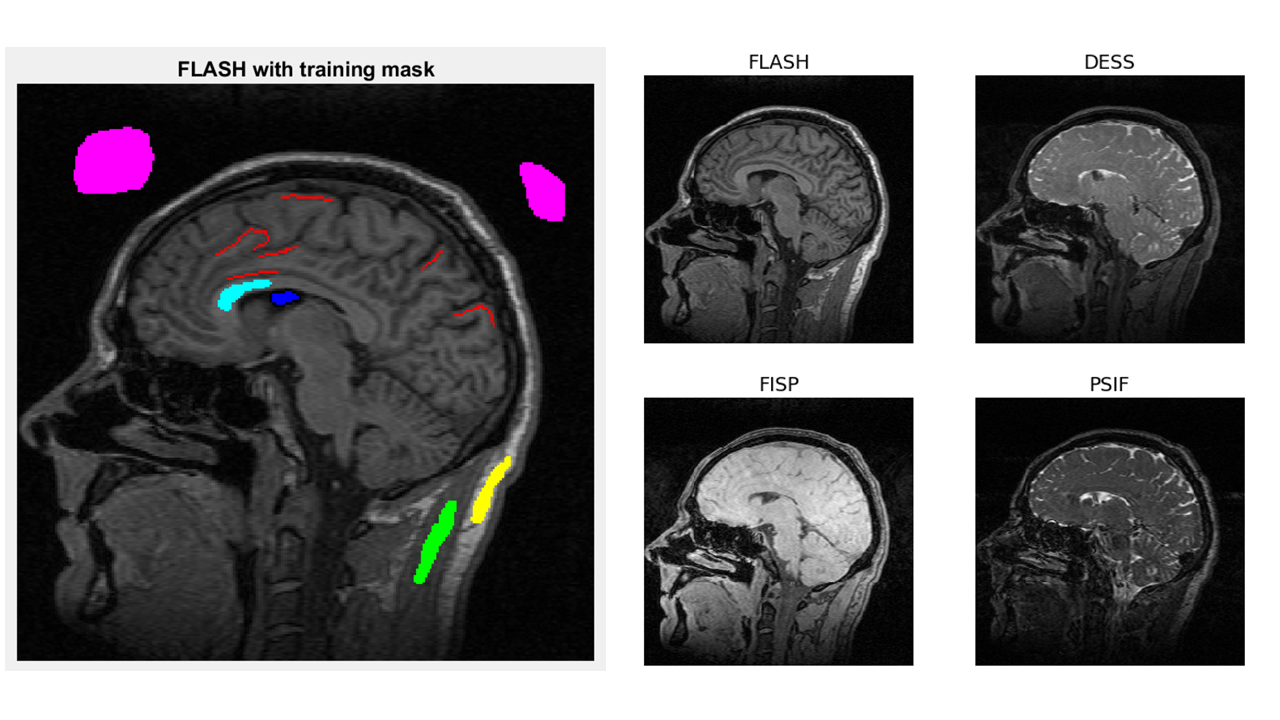

In [2]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

**Import libraries to be used**

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

**Define directory with the data, channel names (MRI pulse sequence acronyms), and class names (tissue types) being involved**

In [4]:
mydata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

## Read the multispectral MR image, multi-class training mask, and binary ROI mask

In [5]:
# Using nibabel to read the multispectral image (and the training mask)
fn_multispectral = '../data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_tmsk = '../data/mri/training_mask_1_6.nii.gz'
tmsk = nib.load(fn_tmsk)
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

**Print properties of the multispectral NIFTI image**

In [6]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_data()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 2D+spectral img_data = ',img_data.shape)
print('dtype of 2D+spectral img_data = ',img_data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral img_data =  (256, 256, 4)
dtype of 2D+spectral img_data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**and corresponing training mask**

In [7]:
print('**Training mask info:**')
print('shape = ', tmsk.header.get_data_shape())
print('voxel size = ', tmsk.header.get_zooms())
print('dtype tmsk = %s' % tmsk.header.get_data_dtype())
tmsk_data = tmsk.get_data().squeeze()
print('min mask value = %.0f' % tmsk_data .min())
print('max mask value = %.0f' % tmsk_data .max())
print('shape of 2D tmsk_data = ', tmsk_data.shape)
print('tmsk affine:', tmsk.affine)

**Training mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype tmsk = int16
min mask value = 0
max mask value = 6
shape of 2D tmsk_data =  (256, 256)
tmsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**and the ROI mask**

In [8]:
print('**Brain ROI mask info:**')
print('shape = ', roimsk.header.get_data_shape())
print('voxel size = ', roimsk.header.get_zooms())
print('dtype roimsk = %s' % roimsk.header.get_data_dtype())
roimsk_data = roimsk.get_data().squeeze()
print('min mask value = %.0f' % roimsk_data .min())
print('max mask value = %.0f' % roimsk_data .max())
print('shape of 2D roimsk_data = ', roimsk_data.shape)
print('roimsk affine:', roimsk.affine)

**Brain ROI mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype roimsk = int16
min mask value = 0
max mask value = 1
shape of 2D roimsk_data =  (256, 256)
roimsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**Display the multispectral MR image**

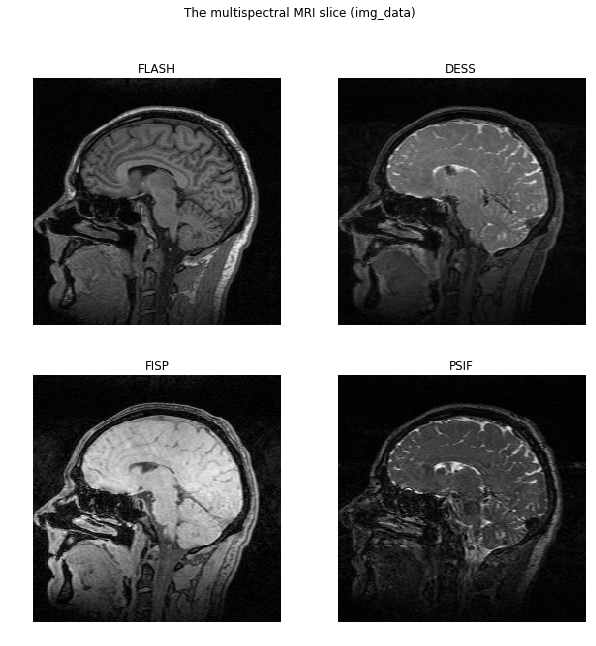

In [9]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(img_data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (img_data)") 
plt.tight_layout
plt.show()

**Display training mask with color coding of tissue classes according to a color table (dictionary) being used during the training (manual labeling of tissue-specific pixels)**

In [10]:
import matplotlib
col_code = {
    'BCK': [255,255,255], # White (background)
    'AIR': [255,0,255],   # Magenta 
    'GM':  [255,0,0],     # Red 
    'WM':  [0,255,255],   # Cyan 
    'CSF': [0,0,255],     # Blue 
    'MUS': [0,255,0],     # Green 
    'FAT': [255,255,0]    # Yellow 
}
cla_names = list(col_code.keys())
ncla = len(cla_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
cla_cmap = matplotlib.cm.get_cmap(mycmap, ncla)   # ncla discrete colors

In [11]:
cla_names_num = []
for i in range(ncla):
    str = cla_names[i] + ' [%d]' % (i)
    cla_names_num.append(str)
cla_names_num

['BCK [0]', 'AIR [1]', 'GM [2]', 'WM [3]', 'CSF [4]', 'MUS [5]', 'FAT [6]']

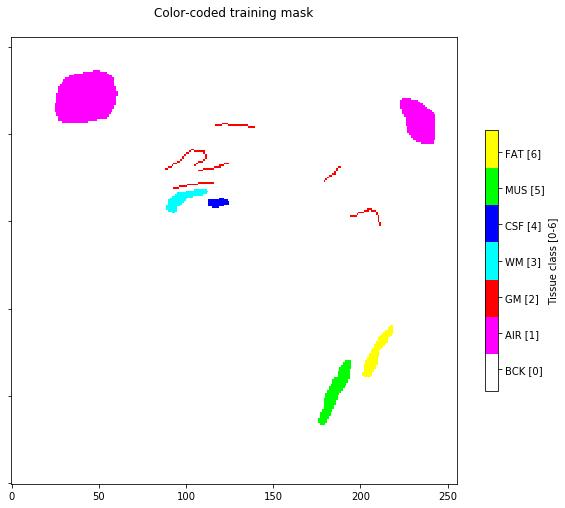

In [12]:
fig, ax = plt.subplots(figsize=(10,12))

cmsk = ax.imshow(tmsk_data[:, :].T)
clim=cmsk.properties()['clim']
cax = ax.imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower', clim=clim)
ax.set_title('Color-coded training mask\n')
ax.axis('on')
ax.set_yticklabels("")
#ax.set_xticklabels("")
cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)
plt.tight_layout
plt.show()

#fig.savefig('%s/prj/ELMED219/results/training_mask_1_6_color_coded.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Constructing a Pandas data frame (FVB) from the MRI data (`img`) and the training mask  (`tmsk`)

FVB = feature vector base

### Features (X) and Labels (y)

The following code generates a figure showing the `features matrix` (data, ${\bf X}$) and the corresponding `labels` (classes, $y$) - modified from the "Python Data Science Handbook" by Jake VanderPlas. 

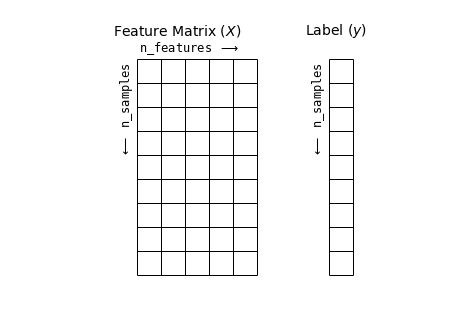

In [13]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.axis('equal')

# Draw features matrix
ax.vlines(range(6), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=0, xmax=5, lw=1)
font_prop = dict(size=12, family='monospace')
ax.text(-1, -1, "Feature Matrix ($X$)", size=14)
ax.text(0.1, -0.3, r'n_features $\longrightarrow$', **font_prop)
ax.text(-0.1, 0.1, r'$\longleftarrow$ n_samples', rotation=90,
        va='top', ha='right', **font_prop)

# Draw labels vector
ax.vlines(range(8, 10), ymin=0, ymax=9, lw=1)
ax.hlines(range(10), xmin=8, xmax=9, lw=1)
ax.text(7, -1, "Label ($y$)", size=14)
ax.text(7.9, 0.1, r'$\longleftarrow$ n_samples', rotation=90,
        va='top', ha='right', **font_prop)

ax.set_ylim(10, -2)

plt.show()

#fig.savefig('assests/features_and_labels_figure.png')

**Find pixel locations corresponding to AIR (class 1), GM (class 2), ..., FAT (class 6)**

In [14]:
frames = pd.DataFrame()   # Create an empty data frame
for cn, cla in enumerate(class_names):
    ind = np.where(tmsk_data == cn+1)  # Find indices (x,y) for given class, class numbers start at 1 (not 0)
    df = pd.DataFrame(np.asarray(img_data[ind[0][:],ind[1][:],:]), columns = chn_names)
    df.insert(len(df.columns), 'Class', class_names[cn].upper())  # Last entry is class name
    frames = frames.append(df)
FVB = pd.concat([frames], ignore_index=True)
print(FVB.head())
print(FVB.tail())
# Class-specific statistics of FVB accross the different features (channels)
#FVB.groupby('Class').describe(percentiles = [0.5]).round(3).T

   FLASH  DESS  FISP  PSIF Class
0      7     6    10     2   AIR
1      0     6     8     0   AIR
2      8     2     4    11   AIR
3      3     7     2    11   AIR
4      5     3     0     6   AIR
      FLASH  DESS  FISP  PSIF Class
1981    281    60   167   176   FAT
1982    305    58   167   164   FAT
1983    303    53   172   185   FAT
1984    281    65   145   176   FAT
1985    287    53   148   214   FAT


**Store to disk the FVB data frame as a .csv file**

In [15]:
FVB.to_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv', index=False)

## Supervised classification using the k-nearest neighbour (kNN) algorithm

See also https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


### Training (labeled) data

**Read the stored FVB data frame with labelled training data**

In [16]:
FVB = pd.read_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv')
FVB.head()

FLASH  DESS  FISP  PSIF Class
0      7     6    10     2   AIR
1      0     6     8     0   AIR
2      8     2     4    11   AIR
3      3     7     2    11   AIR
4      5     3     0     6   AIR

**Extract the data matrix `X` (feature vectors are in float) and corresponding class labels `y` from our FVB data frame**

In [17]:
X_train = FVB.iloc[:, :-1].values.astype(float)
y_train = FVB.iloc[:, -1].values                 # Last column is 'Class'

### Test data included in the brain ROI mask

Read the mask with the delineated brain ROI

In [18]:
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)
roimsk_data = roimsk.get_data().squeeze()
# roimsk_data = np.ones(roimsk_data.shape)   # Using the whole image as ROI

Find all pixel locations in the ROI for extracting test data **X_test** and combine test data and corresponding pixel locations to a Pandas data frame

In [19]:
# Find pixel locations corresponding to brain ROI (verdi 1) 
ind_test = np.where(roimsk_data == 1) 
X_test = np.asarray(img_data[ind_test[0][:],ind_test[1][:],:]) # The multispectral signal intensities
dfT = pd.DataFrame(X_test, columns = chn_names)
dfT.insert(loc = len(dfT.columns),
           column = 'row',
           value = ind_test[0])  # Row of pixel location
dfT.insert(loc = len(dfT.columns),
           column = 'col',
           value = ind_test[1])  # Col of pixel location

In [20]:
dfT.head()

FLASH  DESS  FISP  PSIF  row  col
0    149    66    67    66   20  121
1    129    90    86   106   20  122
2    101    83   146    81   20  123
3     28    79   158    40   20  124
4      7    53   155    67   20  125

In [21]:
dfT.tail()

FLASH  DESS  FISP  PSIF  row  col
35817     10    13    29     6  239  150
35818      8    18    29     6  239  151
35819     12    18    20     8  239  152
35820      0    20    25    16  239  153
35821      9    26    19    19  239  154

### Scaling* of feature vectors  (MRI signal inensity, channel-by-channel) in training and test data

*) Scaling to zero mean and unit standard deviation

In [22]:
scaler = StandardScaler()  
scaler.fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train.astype(float))  
X_test_scaled = scaler.transform(X_test.astype(float)) 

# Make data frame from pair of scaled X_train og y_train to check scaling
dX = pd.DataFrame(X_train_scaled, columns=chn_names)
dy = pd.DataFrame(y_train, columns=['Class'])
FVB_train = pd.concat([dX, dy], axis=1)
FVB_train.describe(percentiles = [0.5]).round(4).T

count  mean     std     min     50%     max
FLASH  1986.0   0.0  1.0003 -0.7119 -0.6019  3.4196
DESS   1986.0  -0.0  1.0003 -0.7713 -0.5691  5.0273
FISP   1986.0   0.0  1.0003 -0.8068 -0.6583  2.4738
PSIF   1986.0   0.0  1.0003 -0.6589 -0.5347  5.3990

### Design a k-nearest neighbour classifier  (KNN) for (unscaled) training data

In [23]:
K = 13
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

Prediction on the training dataset

In [24]:
y_train_pred = classifier.predict(X_train) 

Evaluation of the classification by calculating the **confusion matrix**<br>
(We are here testing the performance of the classifier on the same data as has been used for training - this is called _resubstitution evaluation_)

**Resubstitution estimates** are estimates that are derived by applying a model to the training data from which it was learned

In [25]:
print(confusion_matrix(y_train, y_train_pred))  
print(classification_report(y_train, y_train_pred)) 

[[1250    0    0    0    0    0]
 [   0   51    0    0    0    0]
 [   0    0  170    0    0    0]
 [   0    0    0  136    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    1    0  128]]
              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       1.00      1.00      1.00        51
         FAT       1.00      1.00      1.00       170
          GM       0.99      1.00      1.00       136
         MUS       1.00      1.00      1.00       250
          WM       1.00      0.99      1.00       129

   micro avg       1.00      1.00      1.00      1986
   macro avg       1.00      1.00      1.00      1986
weighted avg       1.00      1.00      1.00      1986



**Your turn!**

 - Experiment with different values of $K$ (e.g. $K=1, 5, 27, 51$) and check the confusion matrix on the training set.
 
 - Why is a diagonal confusion matrix guaranteed when setting $K=1$ ?

We will now set $K=5$, initially, and use scaled signal intensities (feature vectors)  - "zero mean unit variance" - across all classes  

In [26]:
K = 5
classifier = KNeighborsClassifier(n_neighbors=K)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Prediction on brain ROI data (X_test)

In [27]:
y_pred = classifier.predict(X_test_scaled)

In [28]:
print('Number of classified pixels:', len(y_pred))
print('The first 10 predictions in ROI:', y_pred[:10])

Number of classified pixels: 35822
The first 10 predictions in ROI: ['MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'CSF' 'CSF' 'AIR' 'AIR']


**Make a Pandas dataframe for the prediction  enabling remapping of tissue type labels to numerical values using a Python dictionary** 

In [29]:
df_y_pred = pd.DataFrame(y_pred,  columns=['Class'])
print(df_y_pred.info())
df_y_pred.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35822 entries, 0 to 35821
Data columns (total 1 columns):
Class    35822 non-null object
dtypes: object(1)
memory usage: 279.9+ KB
None


0    1    2    3    4
Class  MUS  MUS  MUS  MUS  MUS

In [30]:
df_y_pred.tail().T

35817 35818 35819 35820 35821
Class   AIR   AIR   AIR   AIR   AIR

**Designing a  dictionary that maps a textual tissue type label to a tissue type number**

In [31]:
cla_code = {
    'BCK': 0, # White (background)  Color-coding according to cla_cmap defined above
    'AIR': 1, # Magenta 
    'GM':  2, # Red 
    'WM':  3, # Cyan 
    'CSF': 4, # Blue 
    'MUS': 5, # Green 
    'FAT': 6  # Yellow 
}

df_y_pred['Class'] = df_y_pred['Class'].map(cla_code) # note: if the dictionary does not exhaustively map all
                                             # entries then non-matched entries are changed to NaNs

**Select the FLASH channel (T1w acquisition) to superimpose the pixel-wise tissue type prediction**

In [32]:
# Adding max classnumber + 1 to the FLASH data to avoid mixing data values with predicted class-numbers
cla_data = np.int16((img_data[:,:,0].copy().squeeze() + (df_y_pred.values.max() + 1)*np.ones(tmsk_data.shape)))
mx = cla_data.max()
mn = cla_data.min()
print('min - max =', mn, '-', mx)

cla_data = cla_data/mx
mx = cla_data.max().round(4)
mn = cla_data.min().round(4)
print('min - max =', mn, '-', mx)
cla_data.shape


min - max = 7 - 364
min - max = 0.0192 - 1.0


(256, 256)

Fill the `cla_data` with the pixel-wise KNN predictions (scaled to the interval [0, 1])

In [33]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data[dfT['row'].values, dfT['col'].values] = df_y_pred['Class'].values / mx

### Inspect the prediction using color coding and grey-level coding of the tisue types (classes) 

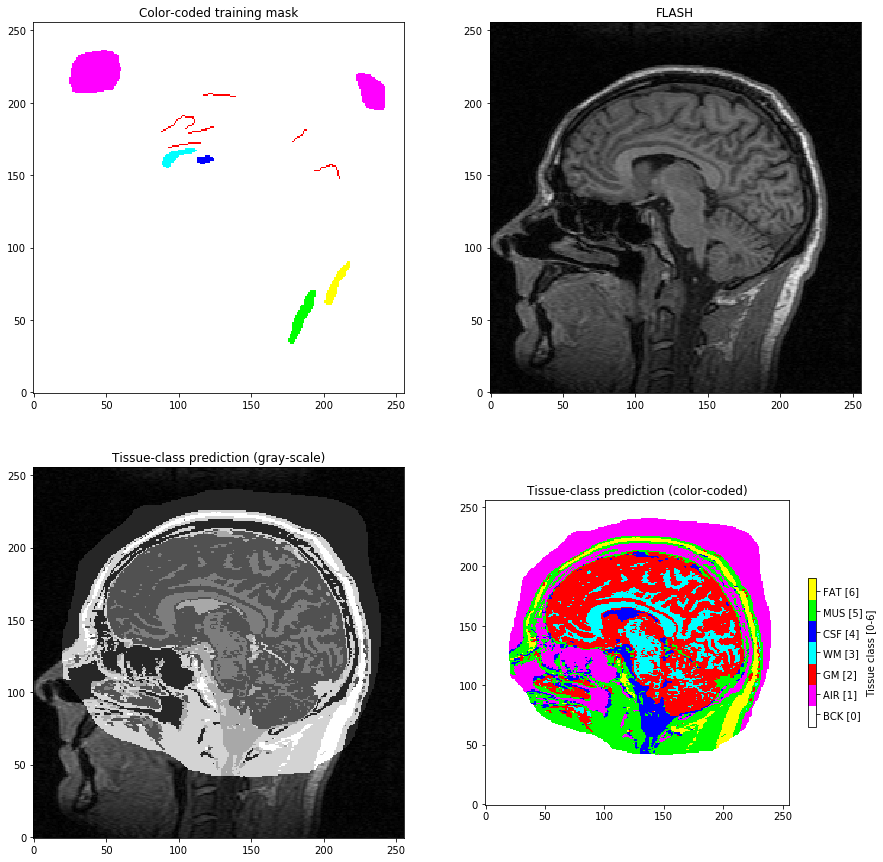

In [34]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()

ax[0].imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower')
ax[0].set_title('Color-coded training mask')
ax[0].axis('on')

ax[1].imshow(img_data[:, :, 0].squeeze().T, cmap='gray', origin='lower')
ax[1].set_title('FLASH')

# Hadamar (elemnt-wise) product np.multiply(a,b)
ax[2].imshow(cla_data[:, :].T / mx, cmap='gray', origin='lower')
ax[2].set_title('Tissue-class prediction (gray-scale)')

ax[3].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[3].set_title('Tissue-class prediction (color-coded)')

cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)

plt.show()

fig.savefig('%s/prj/ELMED219/results/KNN_classification_results_on_flash.png' % (home),
           transparent=False, dpi=300, bbox_inches="tight")

### Experiments with a Random Forest classifier, where the labels are converted to numeric

In [35]:
df_y_train = pd.DataFrame(y_train,  columns=['Class'])
print(df_y_train.info())
df_y_train.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 1 columns):
Class    1986 non-null object
dtypes: object(1)
memory usage: 15.6+ KB
None


0    1    2    3    4
Class  AIR  AIR  AIR  AIR  AIR

In [36]:
df_y_train['Class'] = df_y_train['Class'].map(cla_code)
y_train_num = df_y_train['Class'].values

In [37]:
classifierRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [38]:
classifierRF.fit(X_train_scaled, y_train_num)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [39]:
y_pred_rf = classifierRF.predict(X_test_scaled)

Fyll data med de pixel-vise RF prediksjoner (skalert ned til intervallet [0, 1] )

In [40]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data_rf = cla_data.copy()
cla_data_rf[dfT['row'].values, dfT['col'].values] = y_pred_rf / mx

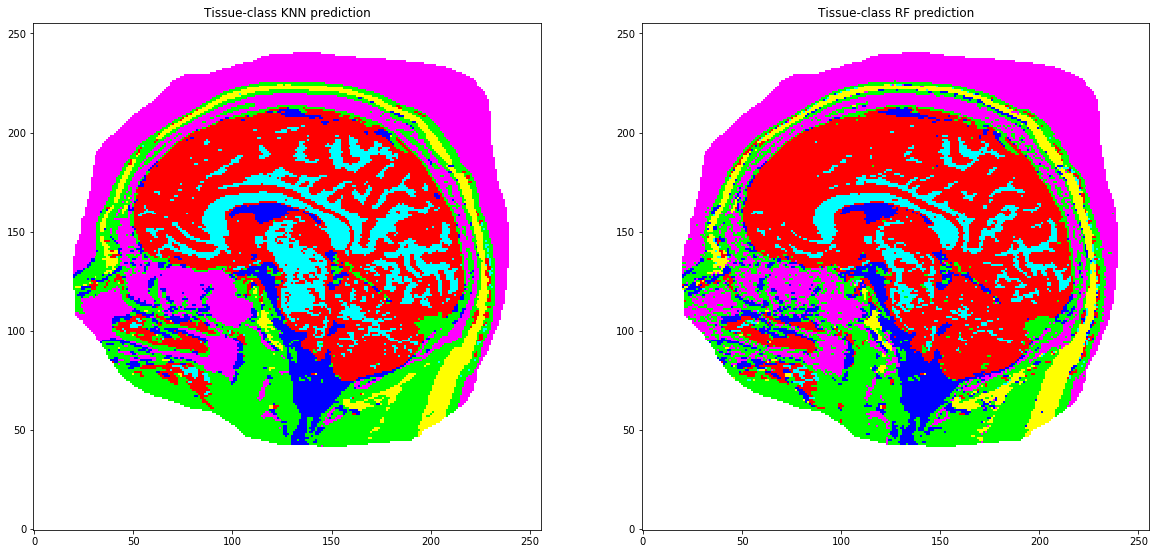

In [41]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[0].set_title('Tissue-class KNN prediction')
ax[1].imshow(np.multiply(cla_data_rf[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[1].set_title('Tissue-class RF prediction')
plt.show()


### Evaluate the result: confusion matrix between KNN prediction (y_pred_knn) and RF prediction (y_pred_rf)

In [42]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar

In [43]:
y_pred_knn = df_y_pred['Class'].values

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_knn, y_pred_rf)

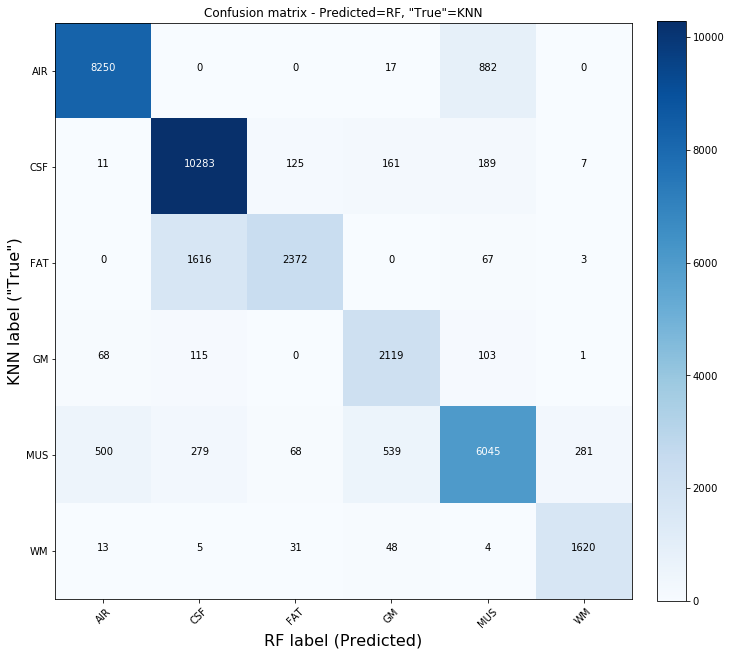

In [45]:
plot_confusion_matrix_with_colorbar(cm, classes=np.unique(y_pred), title='Confusion matrix - Predicted=RF, "True"=KNN', figsize=(10,10))
plt.ylabel('KNN label ("True")')
plt.xlabel('RF label (Predicted)')
plt.show()

## We got 100% predicition accuracy using kNN (k=1) on the training set, i.e. 

In [46]:
X_train = FVB.iloc[:, :-1].values.astype(float)
y_train = FVB.iloc[:, -1].values 
classifier = KNeighborsClassifier(n_neighbors=1)  
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train) 
print(confusion_matrix(y_train, y_train_pred))
print('\ni.e. Prediction accuracy =', 100*accuracy_score(y_train, y_train_pred),'%')

[[1250    0    0    0    0    0]
 [   0   51    0    0    0    0]
 [   0    0  170    0    0    0]
 [   0    0    0  136    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    0    0  129]]

i.e. Prediction accuracy = 100.0 %


## bad or good ?

##  ... the issues of `overfitting` and `underfitting` and the `Bias-Variance` tradeoff

(adapted from the "Python Data Science Handbook" by Jake VanderPlas)

In [47]:
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

**Bias-Variance tradeoff** (see also https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

_What is bias?_

Bias is the difference between the average prediction of our model and the correct value which we are trying to predict.
Of course you only have one model so talking about expected or average prediction values might seem a little strange. However, imagine you could repeat the whole model building process more than once: each time you gather new data and run a new analysis creating a new model. Due to randomness in the underlying data sets, the resulting models will have a range of predictions. Bias measures how far off in general these models' predictions are from the correct value.
Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

_What is variance?_

Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. 
Again, imagine you can repeat the entire model building process multiple times. The variance is how much the predictions for a given point vary between different realizations of the model. Thus, when the changes in the training dataset suggest a small change in the estimate of the target function, there is a low variance. When the changes in the training dataset suggest a large change in the estimate of the target function, there is high variance.
Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.


The _bias-variance tradeoff_ is a central problem in supervised learning. Ideally, one wants to choose a model that both accurately captures the regularities in its training data, but also generalizes well to unseen data. Unfortunately, it is typically impossible to do both simultaneously. High-variance learning methods may be able to represent their training set well but are at risk of overfitting to noisy or unrepresentative training data. In contrast, algorithms with low variance typically produce simpler models that don't tend to overfit but may underfit their training data, failing to capture important regularities.

Models with low bias are usually more complex (e.g. higher-order regression polynomials), enabling them to represent the training set more accurately. In the process, however, they may also represent a large noise component in the training set, making their predictions less accurate - despite their added complexity. In contrast, models with higher bias tend to be relatively simple (low-order or even linear regression polynomials) but may produce lower variance predictions when applied beyond the training set.

_Metaphorically_:

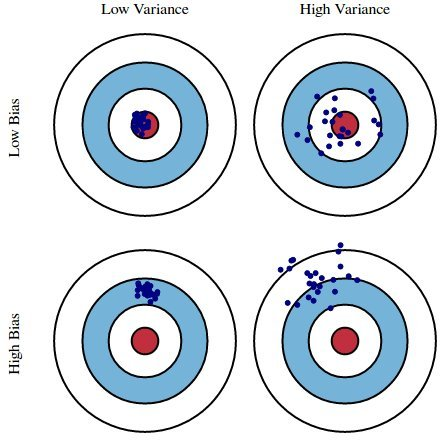

In [49]:
Image(filename='./assets/bias-and-variance.jpg', width=400)

_Low bias / Low variance:_ a person who listens to you very carefully and gives you good answers pretty much all the time.

_Low bias / High variance:_ a knowledgeable person who listens to you and tries to answer the best they can, but that daydreams a lot and may say something totally crazy.

_High bias / Low variance:_ this is someone who usually gives you the same answer, no matter what you ask, and is always wrong about it.

_High bias / High variance:_ someone who takes wild guesses, all of which are sort of wrong; he might be right sometimes due to chance.





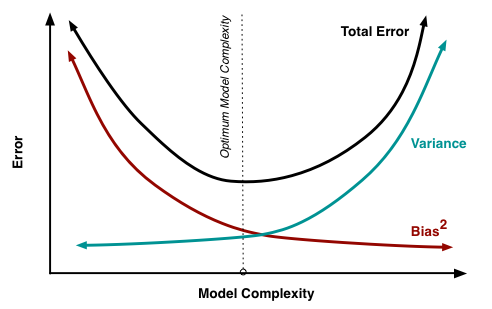

In [50]:
Image(filename='./assets/biasvariance.png', width=600)

Figure. Bias and variance contributing to total error (generalization error). The y-axis represents the test mean squared error and the x-axis represents the flexibility (capacity) of the model which is under consideration.
Adapted from: http://scott.fortmann-roe.com/docs/BiasVariance.html

_The case of k-NN:_<br>
What we are observing here is that increasing $k$ will decrease variance and increase bias. While decreasing $k$ will increase variance and decrease bias. It might seem that the "simplest" and least complex model is the one where $k$ is 1. This reasoning is based on the conception that having more neighbors be involved in calculating the value of a point results in greater complexity. From a computational standpoint this might be true, but it is more accurate to think of complexity from a model standpoint. The greater the variability of the resulting model, the greater its complexity. From this standpoint, we can see that larger values of $k$ result in lower model complexity.

**Bias-Variance tradeoff - example with polynomial regression**

You can play with different model orders in your local copy (my_...ipynb) of thge notebook, e.g.model5, model10, model100 

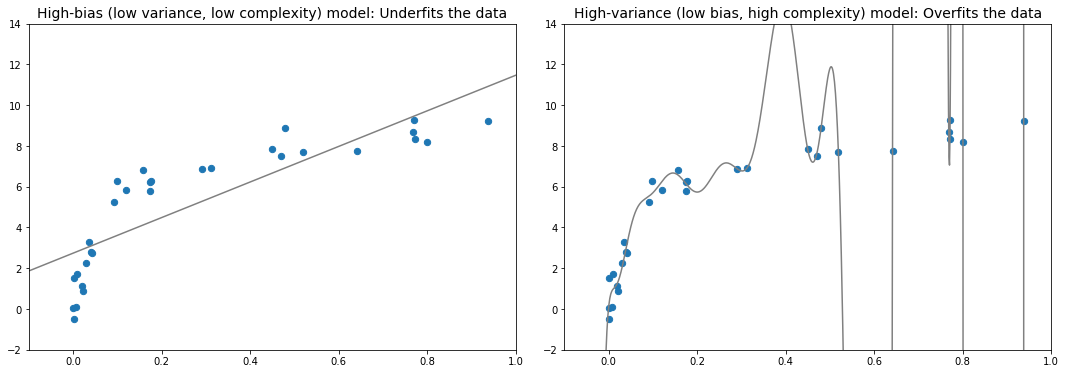

In [51]:
X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model5 = PolynomialRegression(5).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias (low variance, low complexity) model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance (low bias, high complexity) model: Overfits the data', size=14)

plt.show()

#fig.savefig('assets/bias-variance.png')

**Bias-Variance tradeoff Metrics**

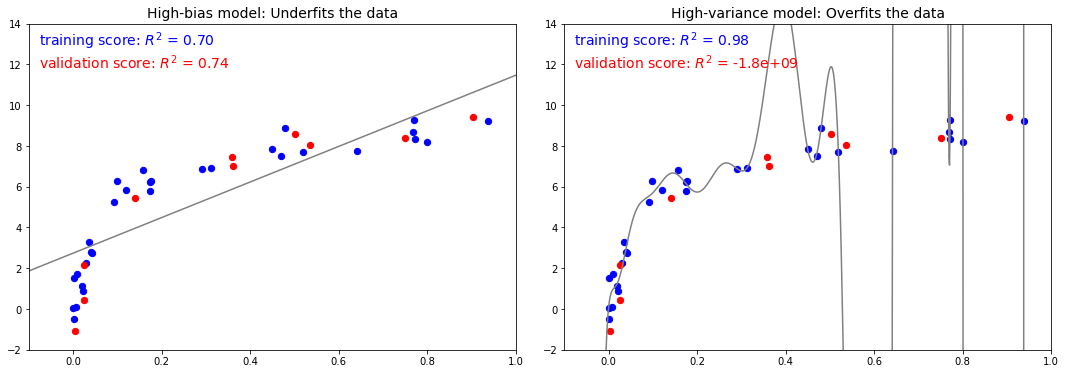

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')

plt.show()
#fig.savefig('assets/bias-variance-metrics.png')

**Validation curve**

At its root, dealing with bias and variance is really about dealing with over- and under-fitting. Bias is reduced and variance is increased in relation to model complexity. As more and more parameters are added to a model, the complexity of the model rises and variance becomes our primary concern while bias steadily falls. For example, as more polynomial terms are added to a linear regression, the greater the resulting model's complexity will be. In other words, bias has a negative first-order derivative in response to model complexity while variance has a positive slope.

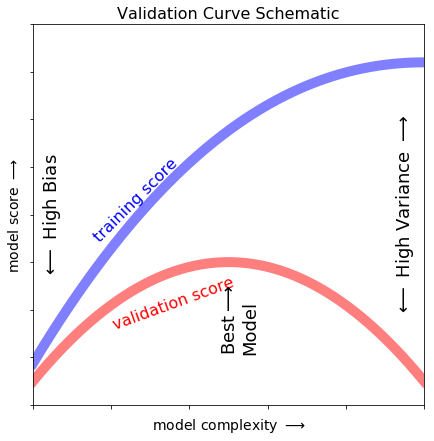

In [53]:
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16)

plt.show()

#fig.savefig('assets/validation-curve.png')

**Learning curve**

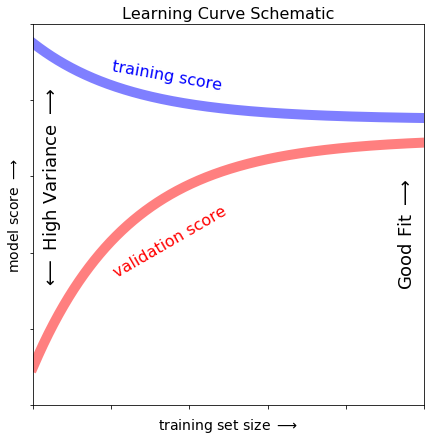

In [54]:
N = np.linspace(0, 1, 1000)
y1 = 0.75 + 0.2 * np.exp(-4 * N)
y2 = 0.7 - 0.6 * np.exp(-4 * N)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(x, y1, lw=10, alpha=0.5, color='blue')
ax.plot(x, y2, lw=10, alpha=0.5, color='red')

ax.text(0.2, 0.88, "training score", rotation=-10, size=16, color='blue')
ax.text(0.2, 0.5, "validation score", rotation=30, size=16, color='red')

ax.text(0.98, 0.45, r'Good Fit $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.02, 0.57, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel(r'training set size $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Learning Curve Schematic", size=16)

plt.show()

#fig.savefig('assets/learning-curve.png')

## Supervised classification using a decision tree (CART) algorithm

Using [DecisionTreeClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) from scikit-learn. See also https://en.wikipedia.org/wiki/Decision_tree_learning <br> and https://scikit-learn.org/stable/modules/tree.html

### Principles and illustration of decision trees

(modified from the "Python Data Science Handbook" by Jake VanderPlas)

**Some helper code** (never mind)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    # contours = ax.contourf(xx, yy, Z, alpha=0.3,
    #                       levels=np.arange(n_classes + 1) - 0.5,
    #                       cmap='viridis', clim=(y.min(), y.max()),
    #                       zorder=1)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)
# Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

### Decision tree example

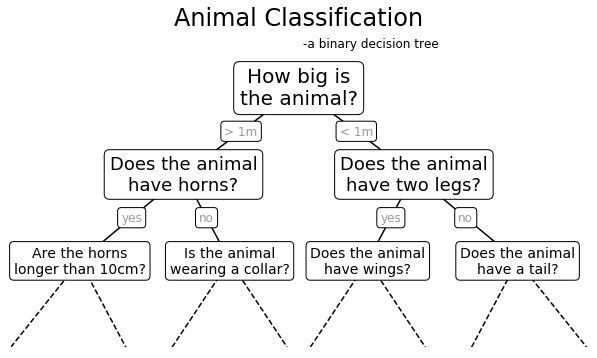

In [56]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Animal Classification\n', size=24)

plt.suptitle('-a binary decision tree',fontsize=12, y=1.075)
    
def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

plt.show()

#fig.savefig('assets/decision-tree.png')

### Decision Tree levels

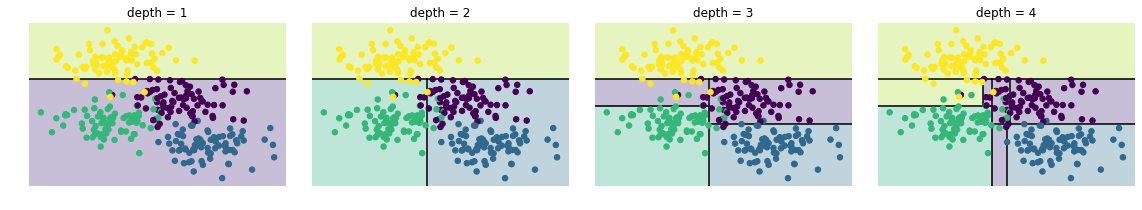

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
     
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

plt.show()
    
#fig.savefig('assets/decision-tree-levels.png')

### Decision Tree overfitting

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


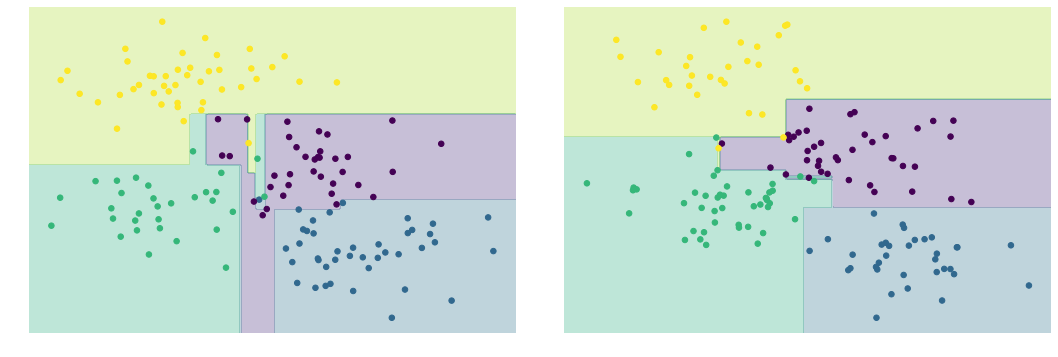

In [58]:
model = DecisionTreeClassifier()

mytree = model.fit(X[::2], y[::2])
print(mytree)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

plt.show()

# fig.savefig('assets/decision-tree-overfitting.png')

In [59]:
print('tree classes:', mytree.classes_)
print('tree n_features:', mytree.n_features_)

tree classes: [0 1 2 3]
tree n_features: 2


In [60]:
mytree.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

**Visualize Decision Tree**

We are using [Graphviz](https://www.graphviz.org), being automatically installed in our `med360` environment with `conda install -c conda-forge graphviz` 

In [61]:
# Check if in our path
!dot -V

dot - graphviz version 2.38.0 (20140413.2041)


In [62]:
import graphviz 
from graphviz import Source
from sklearn.tree import export_graphviz

feature_names = ['f0', 'f1']
class_names = ['c0', 'c1', 'c2', 'c3']

dot_data = export_graphviz(model, out_file='assets/mytree.dot',
                           feature_names=feature_names,
                           class_names=class_names,
                           filled=True,
                           rounded=True,
                           special_characters=True)

In [63]:
# Convert .dot file to .png
!dot -Tpng ./assets/mytree.dot -o ./assets/mytree.png -Gdpi=600

In [64]:
Image(filename = 'assets/mytree.png', width=600)